In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

from datetime import datetime
def time_string():
    # return datetime.now().strftime("%d %B %Y %X")
    return datetime.now().strftime("%X")
impath = 'trash_img'    # путь к папке, в которой будут сохраняться картинки
#switching latex fonts
plt.rcParams.update({
    "text.usetex" : True,
    "font.family" : "serif",
    "font.serif" : "Computer Modern",
    "text.latex.preamble" : r'\usepackage{amsmath} \usepackage{mathtext} \usepackage[english, russian]{babel}'
})
plt.rcParams.update({
    "figure.figsize": (4, 3),
    'figure.dpi': 200
})

# необходимые функции

def err_pres_formatter(value, error):
    """Rounds value and it's error according to scientific conventions"""
    first_digit = (np.array(error/10**np.floor(np.log10(error)), dtype="int"))
    first_digit_position = np.array(np.floor(np.log10(error)), dtype="int")
    ndigits = 1
    if first_digit == 1:
        ndigits += 1
    power = np.log10(abs(value))
    if abs(power//3) >= 1:
        power = 3*int(power//3)
        value /= 10**power
        error /= 10**power
        digit_number = -first_digit_position + ndigits+power-1
        if digit_number <= 0:
            return f"({round(int(value), digit_number)} \u00B1 {round(int(error), digit_number)})$\cdot 10^{{{power}}}$"
        return f"({round(value, digit_number)} \u00B1 {round(error, digit_number)})$\cdot 10^{{{power}}}$"
    digit_number = -first_digit_position + ndigits-1
    if digit_number <= 0:
        return f"{round(int(value), digit_number)} \u00B1 {round(int(error), digit_number)}"
    return f"{round(value, digit_number)} \u00B1 {round(error, digit_number)}"


def lower_upper_limits(domain, fun, popt, pcov, nsigma=1):
    '''Вычисляет минимальные и максимальные значения функции 
    при заданных парамерах и стандартных отклонениях
    в пределах nsigma*стандартное отклонение
    Возвращает:
    minA :(np.array) - массив минимальных значений
    maxA :(np.array) - массив максимальных значений'''
    err = np.sqrt(np.diag(pcov))
    corr = pcov /np.expand_dims(err, 1) / np.expand_dims(err, 0)
    deviations = np.eye(popt.size)*np.expand_dims(err, 1)  
    df = np.expand_dims(fun(domain, *popt), 1) - fun(np.expand_dims(domain, 1), *(np.expand_dims(popt, 1)+np.eye(popt.size)*np.expand_dims(err, 1)))
    dfmatrixes = np.expand_dims(df, 1)*np.expand_dims(df, 2) * np.expand_dims(corr, 0)
    sigm_f = np.sqrt(np.sum(dfmatrixes, axis=(1, 2)))
    return (fun(domain, *popt)-nsigma*sigm_f, fun(domain, *popt)+nsigma*sigm_f)

def plot_approx(x, y, f, par_names_str, fun_name, yerr=None, visApproxError=True, p0=None):
    if yerr is not None:
        popt, pcov = curve_fit(f, x, y, sigma=yerr, absolute_sigma=True, p0=p0)
    else:
        popt, pcov = curve_fit(f, x, y, p0=p0)
    err = np.sqrt(np.diag(pcov))
    for v, er in zip(popt, err):
        print(v,'+-',er)
    approx_label = f"аппроксимация функцией {fun_name}"
    if (err == np.inf).any():
        print('Аппроксимация не сошлась. Попробуй задать начальные параметры p0')
    else:
        par_names = [x.split(',') for x in par_names_str.strip().split("\n") if (len(x) != 0)]
        for i in range(len(par_names)):
            t = par_names[i]
            if len(t) == 2:
                name, units = t
            else:
                name, units = *t, ''
            approx_label += f"\n{name} = {err_pres_formatter(popt[i], err[i])} {units}"
    teorPoints = 50     
    intent = 0.05   # отступ по бокам от обласи экспериментальных данных
    a, b = x.min(), x.max()
    X = np.linspace(a-(b-a)*intent, b+(b-a)*intent, num=teorPoints)
    plt.plot(X, f(X, *popt), 'r', label=approx_label)
    if visApproxError and (pcov != np.inf).all():
        nsigma = 2
        minA, maxA = lower_upper_limits(X, f, popt, pcov, nsigma=nsigma)
        plt.fill_between(X, minA, maxA, alpha=0.4, label=f"область {nsigma} $\sigma$ ошибки")

def make_beautiful_plot(xname, xunit, yname, yunit):
    plt.grid(True, which='minor', linewidth=0.2)
    plt.grid(True, which='major')
    plt.xlabel(fr"{xname}, {xunit}")
    plt.ylabel(fr"{yname}, {yunit}")
    plt.title(fr"{yname}({xname})")
    plt.legend()

In [3]:
# generate data with errors
def gen_linear_data(x_max, n,  k=1, x_eps=0, y_eps=0):
    x = np.linspace(x_max/n, x_max, n, endpoint=True)
    y = k*x
    x_noise = np.random.normal(1, x_eps, n)
    y_noise = np.random.normal(1, y_eps, n)
    xerr = x*x_eps
    yerr = y*y_eps
    x*= x_noise
    y*= y_noise
    if (xerr == 0).any():
        xerr = None
    return x, y, xerr, yerr

In [ ]:
gen_linear_data(x_max, n,  k=1, x_eps=0, y_eps=0):
    x = np.linspace(x_max/n, x_max, n, endpoint=True)
    y = k*x
    x_noise = np.random.normal(1, x_eps, n)
    y_noise = np.random.normal(1, y_eps, n)
    xerr = x*x_eps
    yerr = y*y_eps
    x*= x_noise
    y*= y_noise
    if (xerr == 0).any():
        xerr = None
    return x, y, xerr, yerr

In [4]:
# параметры построения графика и аппроксмации прямой
# пользовательские параметры. Переменные x, y, xerr, yerr дожны содержать данные
''' также необходимо изменить
название графика, 
название функции ,
набор параметров с размерностями через запятую '''
# visApproxError*=hasErrors   # нельзя рисовать ошибки, если их нет)
xname, xunit = r"$x$", ""
yname, yunit = r"$y$", ""
# конец пользовательских параметров

### пытаюсь аппроксимировать функции с ошибками двумя разными методами.

In [5]:
x, y, xerr, yerr = gen_linear_data(10, 10, y_eps=0.1)


0.9644983123648829 +- 0.03162277661163364


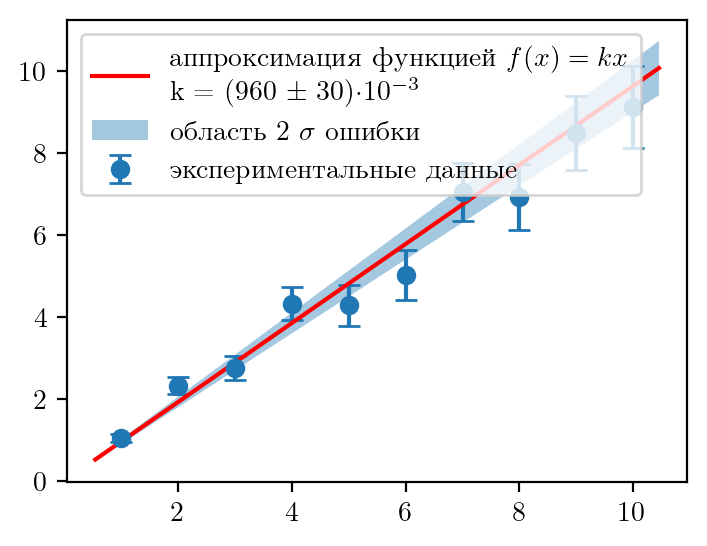

In [6]:

# function to approximate
fun_name = r"$f(x) = kx$"
def f(x, k):
    return k * x
par_names_str = fr'''
k, 
'''

# экспериментальные точки
plt.errorbar(x, y, fmt="o", xerr=xerr, yerr=yerr, label="экспериментальные данные", capsize=4, ms=6)

## scipy approximation

popt, pcov = curve_fit(f, x, y, sigma=yerr, absolute_sigma=True)

err = np.sqrt(np.diag(pcov))
for v, er in zip(popt, err):
    print(v,'+-',er)
approx_label = f"аппроксимация функцией {fun_name}"

par_names = [x.split(',') for x in par_names_str.strip().split("\n") if (len(x) != 0)]
for i in range(len(par_names)):
    t = par_names[i]
    if len(t) == 2:
        name, units = t
    else:
        name, units = *t, ''
    approx_label += f"\n{name} = {err_pres_formatter(popt[i], err[i])}"
teorPoints = 50     
intent = 0.05   # отступ по бокам от обласи экспериментальных данных
a, b = x.min(), x.max()
X = np.linspace(a-(b-a)*intent, b+(b-a)*intent, num=teorPoints)
plt.plot(X, f(X, *popt), 'r', label=approx_label)
if (pcov != np.inf).all():
    nsigma = 2
    minA, maxA = lower_upper_limits(X, f, popt, pcov, nsigma=nsigma)
    plt.fill_between(X, minA, maxA, alpha=0.4, label=f"область {nsigma} $\sigma$ ошибки")

plt.legend();

С ODR та же функция аппроксимируется.

In [7]:
from scipy.odr import *

Beta: [0.93059966]
Beta Std Error: [0.02434868]
Beta Covariance: [[0.00379121]]
Residual Variance: 0.15637694496609586
Inverse Condition #: 1.0
Reason(s) for Halting:
  Sum of squares convergence
0.9305996605544151 +- 0.15604064939978332


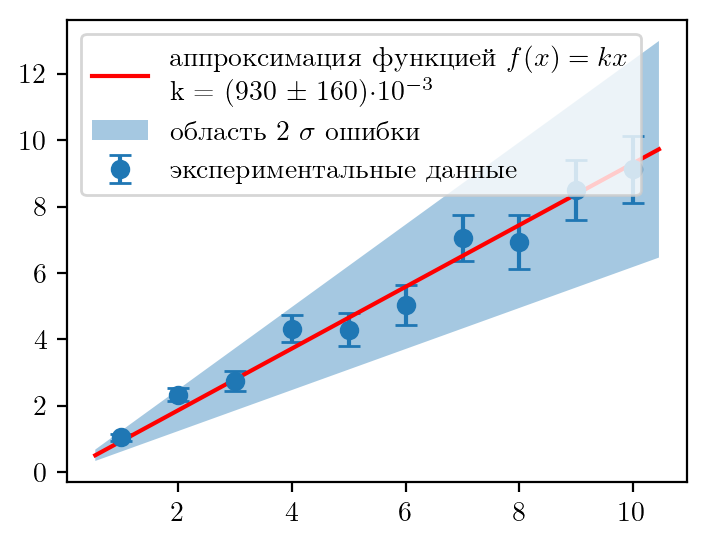

In [8]:
# function to approximate
fun_name = r"$f(x) = kx$"
def F(P, x):
    return P[0] * x
par_names_str = fr'''
k, 
'''
linear = Model(F)
mydata = RealData(x, y, sx=None, sy=yerr)

myodr = ODR(mydata, linear, beta0=[1.])

myoutput = myodr.run()

myoutput.pprint()

popt = myoutput.beta
pcov = myoutput.sd_beta.reshape(1, 1)


# экспериментальные точки
plt.errorbar(x, y, fmt="o", xerr=xerr, yerr=yerr, label="экспериментальные данные", capsize=4, ms=6)

## ODR approximation

err = np.sqrt(np.diag(pcov))
for v, er in zip(popt, err):
    print(v,'+-',er)
approx_label = f"аппроксимация функцией {fun_name}"

par_names = [x.split(',') for x in par_names_str.strip().split("\n") if (len(x) != 0)]
for i in range(len(par_names)):
    t = par_names[i]
    if len(t) == 2:
        name, units = t
    else:
        name, units = *t, ''
    approx_label += f"\n{name} = {err_pres_formatter(popt[i], err[i])}"
teorPoints = 50     
intent = 0.05   # отступ по бокам от обласи экспериментальных данных
a, b = x.min(), x.max()
X = np.linspace(a-(b-a)*intent, b+(b-a)*intent, num=teorPoints)
plt.plot(X, f(X, *popt), 'r', label=approx_label)
if (pcov != np.inf).all():
    nsigma = 2
    minA, maxA = lower_upper_limits(X, f, popt, pcov, nsigma=nsigma)  # pcov*10000000**2
    plt.fill_between(X, minA, maxA, alpha=0.4, label=f"область {nsigma} $\sigma$ ошибки")

plt.legend();

In [9]:
(0.03162277642491051/2.3867988383434346e-09)

13249032.937714348

Почему-то получилась очень маленькая погрешность коэффициента. Возможно дело в нулевой погрешности по оси x. Попробую с нормальной погрешностью оп x.

In [10]:
x, y, xerr, yerr = gen_linear_data(10, 10, y_eps=0.1, x_eps=0.1)


Beta: [0.9328375]
Beta Std Error: [0.02386365]
Beta Covariance: [[0.00356617]]
Residual Variance: 0.15968779394218502
Inverse Condition #: 1.0
Reason(s) for Halting:
  Sum of squares convergence
0.9328374982319836 +- 0.15447865064703917


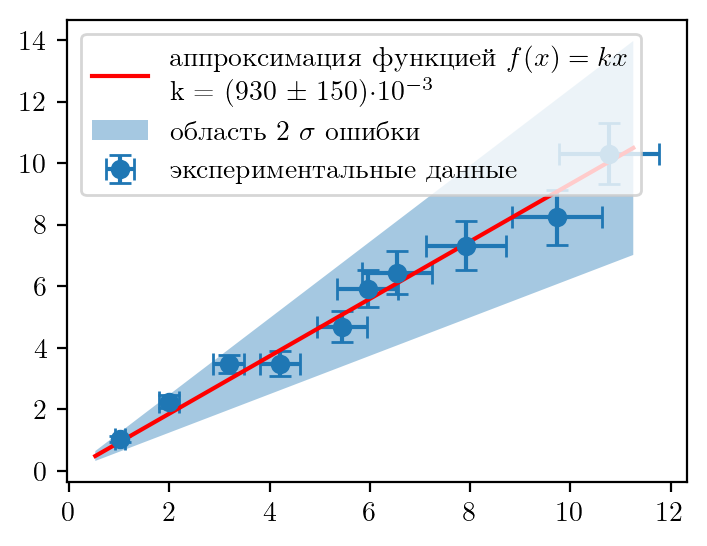

In [11]:
# function to approximate
fun_name = r"$f(x) = kx$"
def F(P, x):
    return P[0] * x
par_names_str = fr'''
k, 
'''
linear = Model(F)
mydata = RealData(x, y, sx=None, sy=yerr)

myodr = ODR(mydata, linear, beta0=[1.])

myoutput = myodr.run()

myoutput.pprint()

popt = myoutput.beta
pcov = myoutput.sd_beta.reshape(1, 1)


# экспериментальные точки
plt.errorbar(x, y, fmt="o", xerr=xerr, yerr=yerr, label="экспериментальные данные", capsize=4, ms=6)

## ODR approximation

err = np.sqrt(np.diag(pcov))
for v, er in zip(popt, err):
    print(v,'+-',er)
approx_label = f"аппроксимация функцией {fun_name}"

par_names = [x.split(',') for x in par_names_str.strip().split("\n") if (len(x) != 0)]
for i in range(len(par_names)):
    t = par_names[i]
    if len(t) == 2:
        name, units = t
    else:
        name, units = *t, ''
    approx_label += f"\n{name} = {err_pres_formatter(popt[i], err[i])}"
teorPoints = 50     
intent = 0.05   # отступ по бокам от обласи экспериментальных данных
a, b = x.min(), x.max()
X = np.linspace(a-(b-a)*intent, b+(b-a)*intent, num=teorPoints)
plt.plot(X, f(X, *popt), 'r', label=approx_label)
if (pcov != np.inf).all():
    nsigma = 2
    minA, maxA = lower_upper_limits(X, f, popt, pcov, nsigma=nsigma)  # pcov*10000000**2
    plt.fill_between(X, minA, maxA, alpha=0.4, label=f"область {nsigma} $\sigma$ ошибки")

plt.legend();

Все понятно. Дело было просто в том, что у меня разброса совсем не было. И похоже, что curve_fit правильно реагирует на отсутствие разброса при большой погрешности, а ODR совсем нет. Возможно это значит, что он работает в режиме yerr - не абсолютные, а относительные. Попробую запустить curve_fit в таком же режиме. 

In [12]:
x, y, xerr, yerr = gen_linear_data(10, 10, y_eps=0.1)


1.0500135749689403 +- 0.031222739749276755


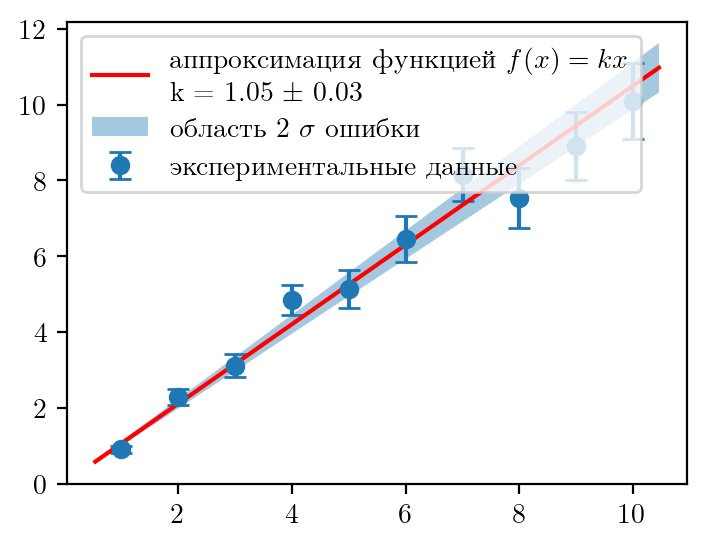

In [13]:

# function to approximate
fun_name = r"$f(x) = kx$"
def f(x, k):
    return k * x
par_names_str = fr'''
k, 
'''

# экспериментальные точки
plt.errorbar(x, y, fmt="o", xerr=xerr, yerr=yerr, label="экспериментальные данные", capsize=4, ms=6)

## scipy approximation

popt, pcov = curve_fit(f, x, y, sigma=yerr, absolute_sigma=False)

err = np.sqrt(np.diag(pcov))
for v, er in zip(popt, err):
    print(v,'+-',er)
approx_label = f"аппроксимация функцией {fun_name}"

par_names = [x.split(',') for x in par_names_str.strip().split("\n") if (len(x) != 0)]
for i in range(len(par_names)):
    t = par_names[i]
    if len(t) == 2:
        name, units = t
    else:
        name, units = *t, ''
    approx_label += f"\n{name} = {err_pres_formatter(popt[i], err[i])}"
teorPoints = 50     
intent = 0.05   # отступ по бокам от обласи экспериментальных данных
a, b = x.min(), x.max()
X = np.linspace(a-(b-a)*intent, b+(b-a)*intent, num=teorPoints)
plt.plot(X, f(X, *popt), 'r', label=approx_label)
if (pcov != np.inf).all():
    nsigma = 2
    minA, maxA = lower_upper_limits(X, f, popt, pcov, nsigma=nsigma)
    plt.fill_between(X, minA, maxA, alpha=0.4, label=f"область {nsigma} $\sigma$ ошибки")

plt.legend();

Нет, все равно у ODR сильно больше погрешность.

### создаю функции для определения погрешности аппроксимации с заданными параметрами.

In [22]:
# scipy аппроксимация с нормальным разбросом.

def find_kerr_scipy_norm(N, x_max, visual=False, absolute_sigma=True, y_eps=0.1, **kwargs):
    
    x, y, xerr, yerr = gen_linear_data(x_max, N, y_eps=y_eps, **kwargs)


    # function to approximate
    fun_name = r"$f(x) = kx$"
    def f(x, k):
        return k * x
    par_names_str = fr'''
    k, 
    '''

    if visual:
        # экспериментальные точки
        plt.errorbar(x, y, fmt="o", xerr=xerr, yerr=yerr, label="экспериментальные данные", capsize=4, ms=6)

    ## scipy approximation

    popt, pcov = curve_fit(f, x, y, sigma=yerr, absolute_sigma=absolute_sigma)
    err = np.sqrt(np.diag(pcov))
    if visual:
        for v, er in zip(popt, err):
            print(v,'+-',er)
        approx_label = f"аппроксимация функцией {fun_name}"

        par_names = [x.split(',') for x in par_names_str.strip().split("\n") if (len(x) != 0)]
        for i in range(len(par_names)):
            t = par_names[i]
            if len(t) == 2:
                name, units = t
            else:
                name, units = *t, ''
            approx_label += f"\n{name} = {err_pres_formatter(popt[i], err[i])}"
        teorPoints = 50     
        intent = 0.05   # отступ по бокам от обласи экспериментальных данных
        a, b = x.min(), x.max()
        X = np.linspace(a-(b-a)*intent, b+(b-a)*intent, num=teorPoints)
        plt.plot(X, f(X, *popt), 'r', label=approx_label)
        if (pcov != np.inf).all():
            nsigma = 2
            minA, maxA = lower_upper_limits(X, f, popt, pcov, nsigma=nsigma)
            plt.fill_between(X, minA, maxA, alpha=0.4, label=f"область {nsigma} $\sigma$ ошибки")
        plt.legend();
    return err[0]

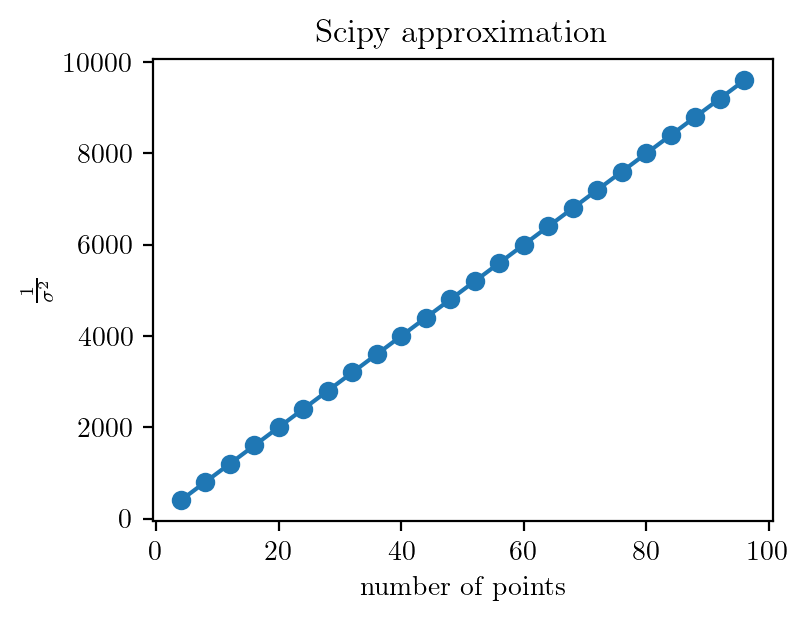

In [15]:
Ns = np.arange(4, 100, 4)
kerr = []
for N in Ns:
    kerr.append(find_kerr_scipy_norm(N, 10))
kerr = np.array(kerr)
plt.plot(Ns, 1/kerr**2, 'o-')
plt.xlabel("number of points")
plt.ylabel(r"$\frac{1}{\sigma^2}$")
plt.title("Scipy approximation");

In [23]:
# scipy аппроксимация с нормальным разбросом.

from scipy.odr import *
def find_kerr_odr_norm(N, x_max, visual=False, absolute_sigma=True, y_eps=0.1, **kwargs):
    
    x, y, xerr, yerr = gen_linear_data(x_max, N, y_eps=y_eps, **kwargs)

    if visual:
        # экспериментальные точки
        plt.errorbar(x, y, fmt="o", xerr=xerr, yerr=yerr, label="экспериментальные данные", capsize=4, ms=6)

    ## ODR approximation

    
    fun_name = r"$f(x) = kx$"
    def F(P, x):
        return P[0] * x
    par_names_str = fr'''
    k, 
    '''
    linear = Model(F)
    mydata = RealData(x, y, sx=None, sy=yerr)

    myodr = ODR(mydata, linear, beta0=[1.])

    myoutput = myodr.run()

    # myoutput.pprint()

    popt = myoutput.beta
    pcov = myoutput.sd_beta.reshape(1, 1)

    err = np.sqrt(np.diag(pcov))
    if visual:
        for v, er in zip(popt, err):
            print(v,'+-',er)
        approx_label = f"аппроксимация функцией {fun_name}"

        par_names = [x.split(',') for x in par_names_str.strip().split("\n") if (len(x) != 0)]
        for i in range(len(par_names)):
            t = par_names[i]
            if len(t) == 2:
                name, units = t
            else:
                name, units = *t, ''
            approx_label += f"\n{name} = {err_pres_formatter(popt[i], err[i])}"
        teorPoints = 50     
        intent = 0.05   # отступ по бокам от обласи экспериментальных данных
        a, b = x.min(), x.max()
        X = np.linspace(a-(b-a)*intent, b+(b-a)*intent, num=teorPoints)
        plt.plot(X, f(X, *popt), 'r', label=approx_label)
        if (pcov != np.inf).all():
            nsigma = 2
            minA, maxA = lower_upper_limits(X, f, popt, pcov, nsigma=nsigma)
            plt.fill_between(X, minA, maxA, alpha=0.4, label=f"область {nsigma} $\sigma$ ошибки")
        plt.legend();
    return err[0]

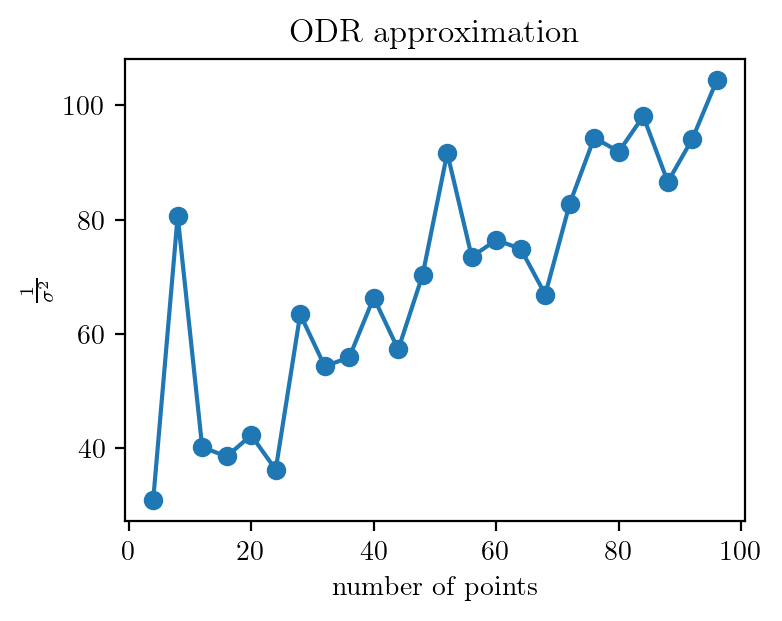

In [17]:
Ns = np.arange(4, 100, 4)
kerr = []
for N in Ns:
    kerr.append(find_kerr_odr_norm(N, 10))
kerr = np.array(kerr)
plt.plot(Ns, 1/kerr**2, 'o-')
plt.xlabel("number of points")
plt.ylabel(r"$\frac{1}{\sigma^2}$")
plt.title("ODR approximation");

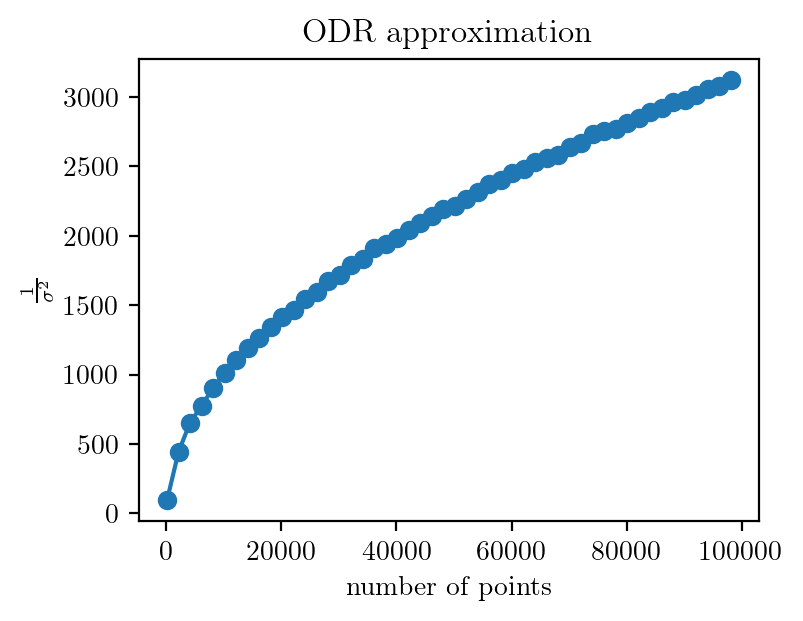

In [18]:
Ns = np.arange(100, 100000, 2000)
kerr = []
for N in Ns:
    kerr.append(find_kerr_odr_norm(N, 10))
kerr = np.array(kerr)
plt.plot(Ns, 1/kerr**2, 'o-')
plt.xlabel("number of points")
plt.ylabel(r"$\frac{1}{\sigma^2}$")
plt.title("ODR approximation");

Очень интересно. тут явно виден другой характер зависимости погрешности от количества точек. Хотя для чистоты эксперимента надо проверить в тех же диапазонах scipy

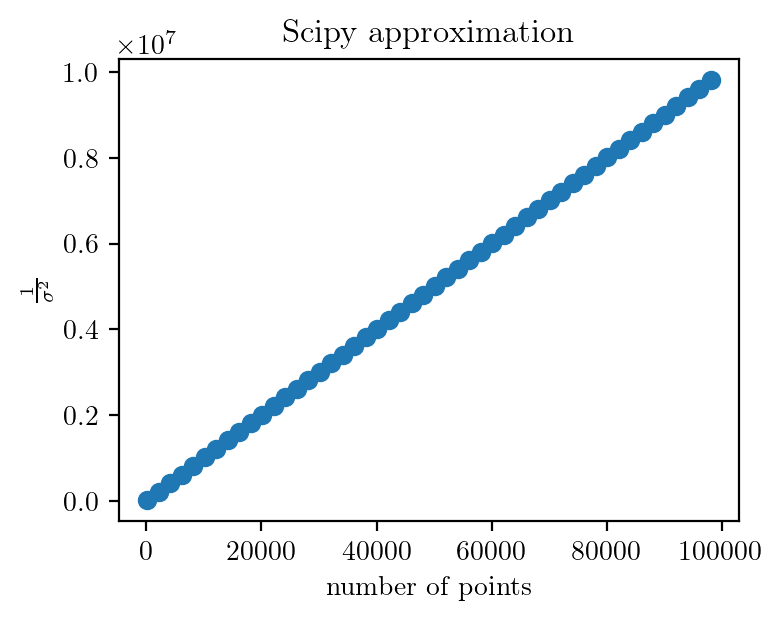

In [19]:
Ns = np.arange(100, 100000, 2000)
kerr = []
for N in Ns:
    kerr.append(find_kerr_scipy_norm(N, 10))
kerr = np.array(kerr)
plt.plot(Ns, 1/kerr**2, 'o-')
plt.xlabel("number of points")
plt.ylabel(r"$\frac{1}{\sigma^2}$")
plt.title("Scipy approximation");

Теперь зная эту странность можно проверить, как погрешность зависит у них от погрешности и разброса данных.

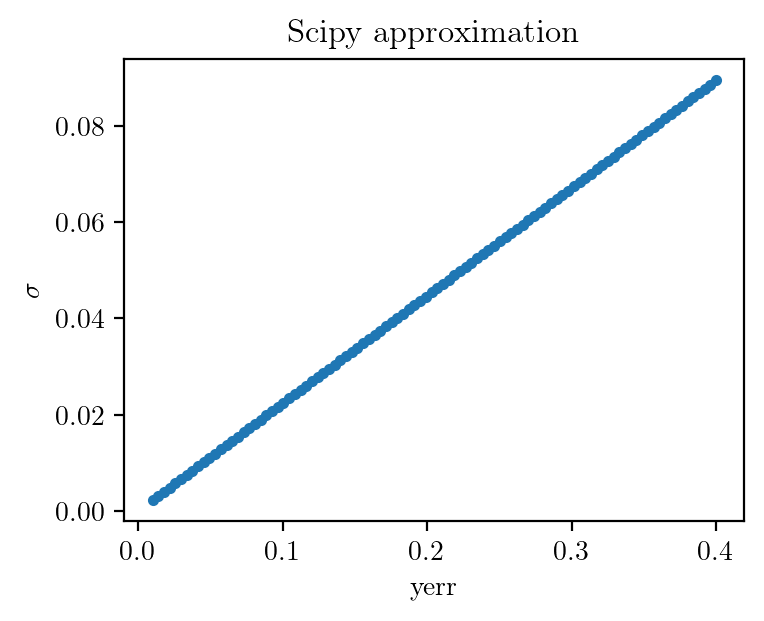

In [25]:
yerrs = np.linspace(0.01, 0.4, 100)
kerr = []
for yerr in yerrs:
    kerr.append(find_kerr_scipy_norm(20, 10, y_eps=yerr))
kerr = np.array(kerr)
plt.plot(yerrs, kerr, 'o-', ms=3)
plt.xlabel("yerr")
plt.ylabel(r"$\sigma$")
plt.title("Scipy approximation");

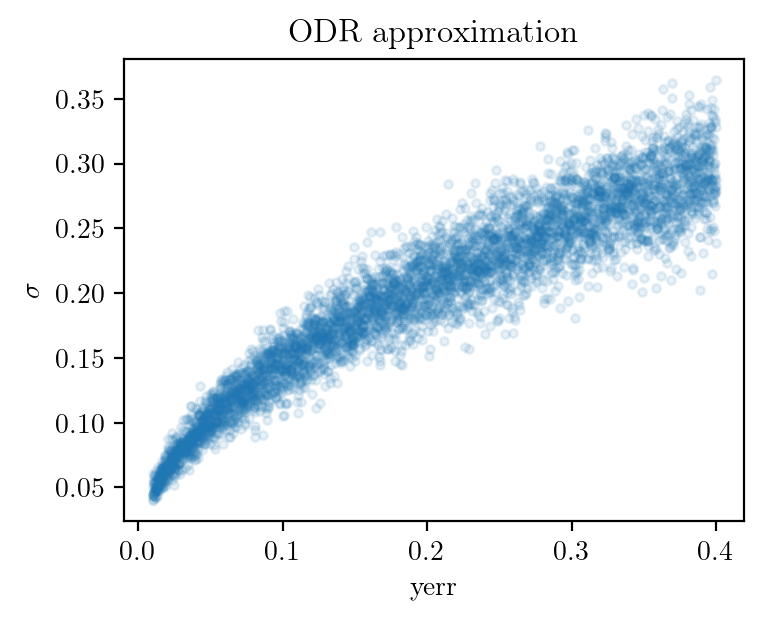

In [31]:
yerrs = np.linspace(0.01, 0.4, 5000)
kerr = []
for yerr in yerrs:
    kerr.append(find_kerr_odr_norm(20, 10, y_eps=yerr))
kerr = np.array(kerr)
plt.plot(yerrs, kerr, 'o', ms=3, alpha=0.1)
plt.xlabel("yerr")
plt.ylabel(r"$\sigma$")
plt.title("ODR approximation");

Может проблема просто в том, что odr выдает сразу корень из ковариаций? Надо пропробовать ставнить эти величины у двух аппроксимаций

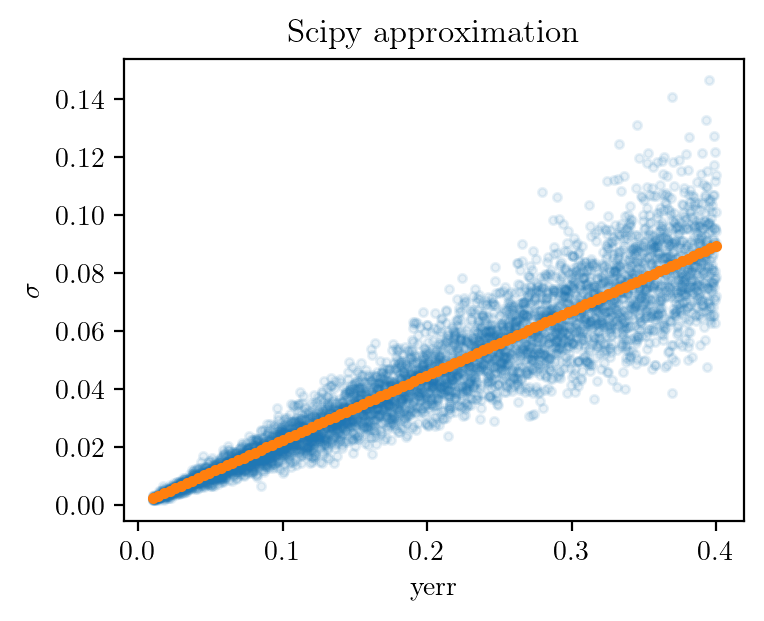

In [32]:
yerrs = np.linspace(0.01, 0.4, 5000)
kerr = []
for yerr in yerrs:
    kerr.append(find_kerr_odr_norm(20, 10, y_eps=yerr))
kerr = np.array(kerr)
plt.plot(yerrs, kerr**2, 'o', ms=3, alpha=0.1, label="ODR approximation")
plt.xlabel("yerr")
plt.ylabel(r"$\sigma$")

yerrs = np.linspace(0.01, 0.4, 100)
kerr = []
for yerr in yerrs:
    kerr.append(find_kerr_scipy_norm(20, 10, y_eps=yerr))
kerr = np.array(kerr)
plt.plot(yerrs, kerr, 'o-', ms=3, label="Scipy approximation")
plt.xlabel("yerr")
plt.ylabel(r"$\sigma$")
plt.title("Scipy approximation");

Другое дело. А если теперь сравнить зависимости от количества точек

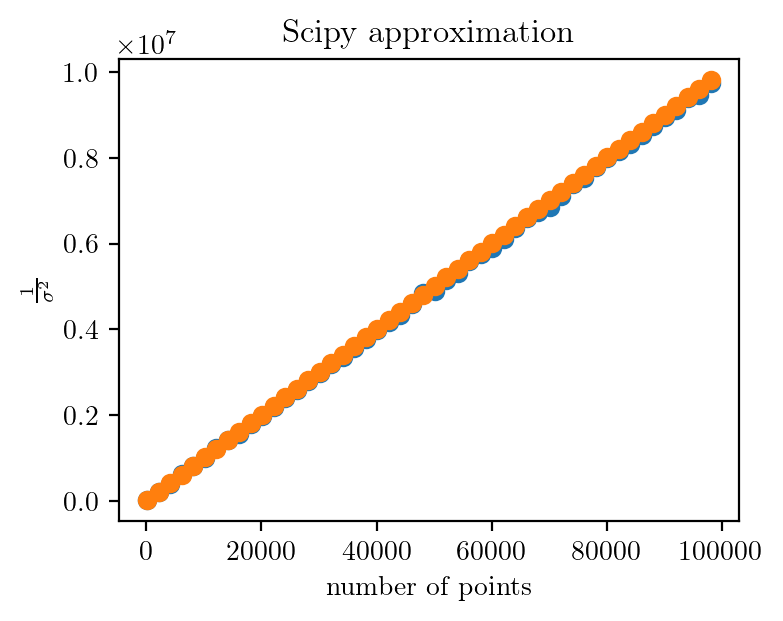

In [33]:
Ns = np.arange(100, 100000, 2000)
kerr = []
for N in Ns:
    kerr.append(find_kerr_odr_norm(N, 10))
kerr = np.array(kerr)
plt.plot(Ns, 1/kerr**4, 'o-')
plt.xlabel("number of points")
plt.ylabel(r"$\frac{1}{\sigma^2}$")
plt.title("ODR approximation");

Ns = np.arange(100, 100000, 2000)
kerr = []
for N in Ns:
    kerr.append(find_kerr_scipy_norm(N, 10))
kerr = np.array(kerr)
plt.plot(Ns, 1/kerr**2, 'o-')
plt.xlabel("number of points")
plt.ylabel(r"$\frac{1}{\sigma^2}$")
plt.title("Scipy approximation");

Отлично тоже совпадает. Можно использовать такой код для аппроксимации с помощью odr.

In [ ]:
x, y, xerr, yerr = gen_linear_data(10, 10, y_eps=0.1)


In [ ]:
from scipy.odr import *

Beta: [1.03588554]
Beta Std Error: [0.02548923]
Beta Covariance: [[0.00321597]]
Residual Variance: 0.2020234866743141
Inverse Condition #: 1.0
Reason(s) for Halting:
  Sum of squares convergence
1.035885539767727 +- 0.02548923175697868


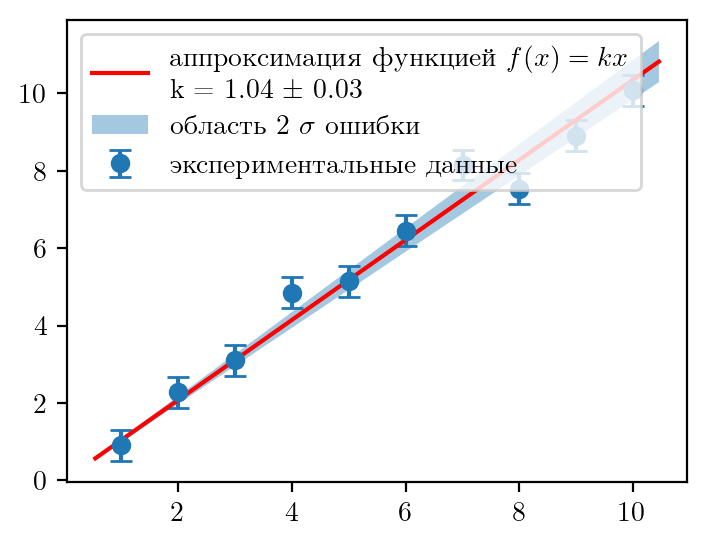

In [34]:
# function to approximate
fun_name = r"$f(x) = kx$"
def F(P, x):
    return P[0] * x
par_names_str = fr'''
k, 
'''
linear = Model(F)
mydata = RealData(x, y, sx=None, sy=yerr)

myodr = ODR(mydata, linear, beta0=[1.])

myoutput = myodr.run()

myoutput.pprint()

popt = myoutput.beta
pcov = myoutput.sd_beta.reshape(1, 1)**2


# экспериментальные точки
plt.errorbar(x, y, fmt="o", xerr=xerr, yerr=yerr, label="экспериментальные данные", capsize=4, ms=6)

## ODR approximation

err = np.sqrt(np.diag(pcov))
for v, er in zip(popt, err):
    print(v,'+-',er)
approx_label = f"аппроксимация функцией {fun_name}"

par_names = [x.split(',') for x in par_names_str.strip().split("\n") if (len(x) != 0)]
for i in range(len(par_names)):
    t = par_names[i]
    if len(t) == 2:
        name, units = t
    else:
        name, units = *t, ''
    approx_label += f"\n{name} = {err_pres_formatter(popt[i], err[i])}"
teorPoints = 50     
intent = 0.05   # отступ по бокам от обласи экспериментальных данных
a, b = x.min(), x.max()
X = np.linspace(a-(b-a)*intent, b+(b-a)*intent, num=teorPoints)
plt.plot(X, f(X, *popt), 'r', label=approx_label)
if (pcov != np.inf).all():
    nsigma = 2
    minA, maxA = lower_upper_limits(X, f, popt, pcov, nsigma=nsigma)  # pcov*10000000**2
    plt.fill_between(X, minA, maxA, alpha=0.4, label=f"область {nsigma} $\sigma$ ошибки")

plt.legend();

In [36]:
dir(myoutput)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'beta',
 'cov_beta',
 'delta',
 'eps',
 'info',
 'inv_condnum',
 'iwork',
 'pprint',
 'rel_error',
 'res_var',
 'sd_beta',
 'stopreason',
 'sum_square',
 'sum_square_delta',
 'sum_square_eps',
 'work',
 'work_ind',
 'xplus',
 'y']

In [37]:
myoutput.cov_beta

array([[0.00321597]])

### Двойная хорошая аппроксимация

In [54]:
x, y, xerr, yerr = gen_linear_data(10, 30, y_eps=0.1)


In [40]:
from scipy.odr import *

Beta: [1.03676013]
Beta Std Error: [0.02111606]
Beta Covariance: [[0.00159209]]
Residual Variance: 0.28006372298574317
Inverse Condition #: 1.0000000000000002
Reason(s) for Halting:
  Sum of squares convergence
1.0367601318621174 +- 0.021116057883454328
1.0060618056335888 +- 0.01825741856637725


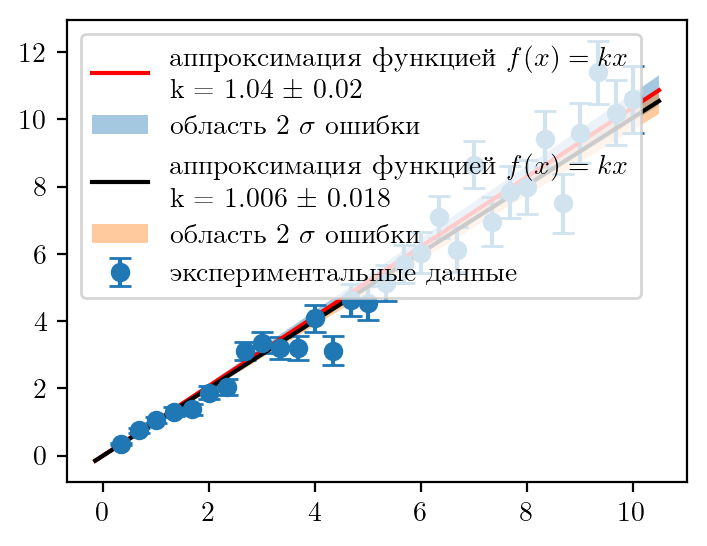

In [55]:
# function to approximate
fun_name = r"$f(x) = kx$"
def F(P, x):
    return P[0] * x
par_names_str = fr'''
k, 
'''
linear = Model(F)
mydata = RealData(x, y, sx=None, sy=yerr)

myodr = ODR(mydata, linear, beta0=[1.])

myoutput = myodr.run()

myoutput.pprint()

popt = myoutput.beta
pcov = myoutput.sd_beta.reshape(1, 1)**2


# экспериментальные точки
plt.errorbar(x, y, fmt="o", xerr=xerr, yerr=yerr, label="экспериментальные данные", capsize=4, ms=6)

## ODR approximation

err = np.sqrt(np.diag(pcov))
for v, er in zip(popt, err):
    print(v,'+-',er)
approx_label = f"аппроксимация функцией {fun_name}"

par_names = [x.split(',') for x in par_names_str.strip().split("\n") if (len(x) != 0)]
for i in range(len(par_names)):
    t = par_names[i]
    if len(t) == 2:
        name, units = t
    else:
        name, units = *t, ''
    approx_label += f"\n{name} = {err_pres_formatter(popt[i], err[i])}"
teorPoints = 50     
intent = 0.05   # отступ по бокам от обласи экспериментальных данных
a, b = x.min(), x.max()
X = np.linspace(a-(b-a)*intent, b+(b-a)*intent, num=teorPoints)
plt.plot(X, f(X, *popt), 'r', label=approx_label)
if (pcov != np.inf).all():
    nsigma = 2
    minA, maxA = lower_upper_limits(X, f, popt, pcov, nsigma=nsigma)  # pcov*10000000**2
    plt.fill_between(X, minA, maxA, alpha=0.4, label=f"область {nsigma} $\sigma$ ошибки")


## scipy approximation

# function to approximate
fun_name = r"$f(x) = kx$"
def f(x, k):
    return k * x
par_names_str = fr'''
k, 
'''
popt, pcov = curve_fit(f, x, y, sigma=yerr, absolute_sigma=True)

err = np.sqrt(np.diag(pcov))
for v, er in zip(popt, err):
    print(v,'+-',er)
approx_label = f"аппроксимация функцией {fun_name}"

par_names = [x.split(',') for x in par_names_str.strip().split("\n") if (len(x) != 0)]
for i in range(len(par_names)):
    t = par_names[i]
    if len(t) == 2:
        name, units = t
    else:
        name, units = *t, ''
    approx_label += f"\n{name} = {err_pres_formatter(popt[i], err[i])}"
teorPoints = 50     
intent = 0.05   # отступ по бокам от обласи экспериментальных данных
a, b = x.min(), x.max()
X = np.linspace(a-(b-a)*intent, b+(b-a)*intent, num=teorPoints)
plt.plot(X, f(X, *popt), 'black', label=approx_label)
if (pcov != np.inf).all():
    nsigma = 2
    minA, maxA = lower_upper_limits(X, f, popt, pcov, nsigma=nsigma)
    plt.fill_between(X, minA, maxA, alpha=0.4, label=f"область {nsigma} $\sigma$ ошибки")


plt.legend();

In [56]:
pcov**0.5

array([[0.01825742]])

In [57]:
myoutput.sd_beta

array([0.02111606])

In [58]:
myoutput.cov_beta**0.5

array([[0.03990106]])

При 10 точках есть различие раза в 1.5, но при 30 уже почти одинково, если смотреть по sd_beta

А если добавить разброс по оси X

In [59]:
x, y, xerr, yerr = gen_linear_data(10, 30, y_eps=0.1, x_eps=0.3)


Beta: [0.96995431]
Beta Std Error: [0.0641654]
Beta Covariance: [[0.00288502]]
Residual Variance: 1.4270931494891241
Inverse Condition #: 1.0
Reason(s) for Halting:
  Sum of squares convergence
0.9699543092986621 +- 0.06416539810327287
0.8700076514117039 +- 0.016632867143938208


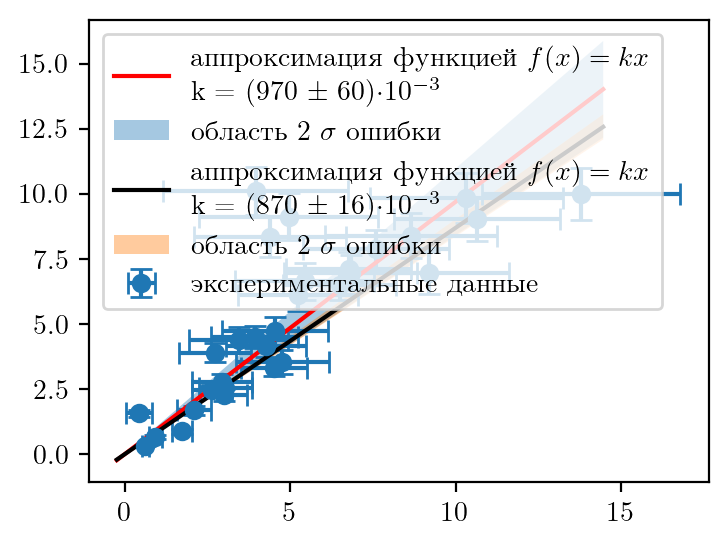

In [64]:
# function to approximate
fun_name = r"$f(x) = kx$"
def F(P, x):
    return P[0] * x
par_names_str = fr'''
k, 
'''
linear = Model(F)
mydata = RealData(x, y, sx=xerr, sy=yerr)

myodr = ODR(mydata, linear, beta0=[1.])

myoutput = myodr.run()

myoutput.pprint()

popt = myoutput.beta
pcov = myoutput.sd_beta.reshape(1, 1)**2


# экспериментальные точки
plt.errorbar(x, y, fmt="o", xerr=xerr, yerr=yerr, label="экспериментальные данные", capsize=4, ms=6)

## ODR approximation

err = np.sqrt(np.diag(pcov))
for v, er in zip(popt, err):
    print(v,'+-',er)
approx_label = f"аппроксимация функцией {fun_name}"

par_names = [x.split(',') for x in par_names_str.strip().split("\n") if (len(x) != 0)]
for i in range(len(par_names)):
    t = par_names[i]
    if len(t) == 2:
        name, units = t
    else:
        name, units = *t, ''
    approx_label += f"\n{name} = {err_pres_formatter(popt[i], err[i])}"
teorPoints = 50     
intent = 0.05   # отступ по бокам от обласи экспериментальных данных
a, b = x.min(), x.max()
X = np.linspace(a-(b-a)*intent, b+(b-a)*intent, num=teorPoints)
plt.plot(X, f(X, *popt), 'r', label=approx_label)
if (pcov != np.inf).all():
    nsigma = 2
    minA, maxA = lower_upper_limits(X, f, popt, pcov, nsigma=nsigma)  # pcov*10000000**2
    plt.fill_between(X, minA, maxA, alpha=0.4, label=f"область {nsigma} $\sigma$ ошибки")


## scipy approximation

# function to approximate
fun_name = r"$f(x) = kx$"
def f(x, k):
    return k * x
par_names_str = fr'''
k, 
'''
popt, pcov = curve_fit(f, x, y, sigma=yerr, absolute_sigma=True)

err = np.sqrt(np.diag(pcov))
for v, er in zip(popt, err):
    print(v,'+-',er)
approx_label = f"аппроксимация функцией {fun_name}"

par_names = [x.split(',') for x in par_names_str.strip().split("\n") if (len(x) != 0)]
for i in range(len(par_names)):
    t = par_names[i]
    if len(t) == 2:
        name, units = t
    else:
        name, units = *t, ''
    approx_label += f"\n{name} = {err_pres_formatter(popt[i], err[i])}"
teorPoints = 50     
intent = 0.05   # отступ по бокам от обласи экспериментальных данных
a, b = x.min(), x.max()
X = np.linspace(a-(b-a)*intent, b+(b-a)*intent, num=teorPoints)
plt.plot(X, f(X, *popt), 'black', label=approx_label)
if (pcov != np.inf).all():
    nsigma = 2
    minA, maxA = lower_upper_limits(X, f, popt, pcov, nsigma=nsigma)
    plt.fill_between(X, minA, maxA, alpha=0.4, label=f"область {nsigma} $\sigma$ ошибки")


plt.legend();

Вот это огромное преимущество odr сейчас показывает. Curve_fit вообще фигню какую-то дает и на уверенных щах.

Beta: [1.00114024]
Beta Std Error: [0.0005665]
Beta Covariance: [[0.00835273]]
Residual Variance: 3.842116863527074e-05
Inverse Condition #: 1.0
Reason(s) for Halting:
  Sum of squares convergence
1.0011402424039746 +- 0.0005664993636386257
1.0011402416232138 +- 0.09139160703279324


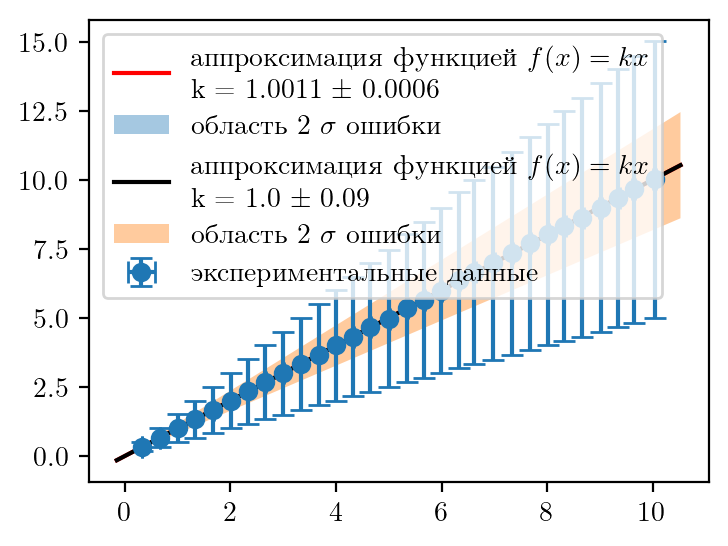

In [67]:
# Эксперимент с маленьким разбросом и большой погрешностью

x, y, xerr, yerr = gen_linear_data(10, 30, y_eps=0.003, x_eps=0.003)
yerr = 0.5*y
# function to approximate
fun_name = r"$f(x) = kx$"
def F(P, x):
    return P[0] * x
par_names_str = fr'''
k, 
'''
linear = Model(F)
mydata = RealData(x, y, sx=xerr, sy=yerr)

myodr = ODR(mydata, linear, beta0=[1.])

myoutput = myodr.run()

myoutput.pprint()

popt = myoutput.beta
pcov = myoutput.sd_beta.reshape(1, 1)**2


# экспериментальные точки
plt.errorbar(x, y, fmt="o", xerr=xerr, yerr=yerr, label="экспериментальные данные", capsize=4, ms=6)

## ODR approximation

err = np.sqrt(np.diag(pcov))
for v, er in zip(popt, err):
    print(v,'+-',er)
approx_label = f"аппроксимация функцией {fun_name}"

par_names = [x.split(',') for x in par_names_str.strip().split("\n") if (len(x) != 0)]
for i in range(len(par_names)):
    t = par_names[i]
    if len(t) == 2:
        name, units = t
    else:
        name, units = *t, ''
    approx_label += f"\n{name} = {err_pres_formatter(popt[i], err[i])}"
teorPoints = 50     
intent = 0.05   # отступ по бокам от обласи экспериментальных данных
a, b = x.min(), x.max()
X = np.linspace(a-(b-a)*intent, b+(b-a)*intent, num=teorPoints)
plt.plot(X, f(X, *popt), 'r', label=approx_label)
if (pcov != np.inf).all():
    nsigma = 2
    minA, maxA = lower_upper_limits(X, f, popt, pcov, nsigma=nsigma)  # pcov*10000000**2
    plt.fill_between(X, minA, maxA, alpha=0.4, label=f"область {nsigma} $\sigma$ ошибки")


## scipy approximation

# function to approximate
fun_name = r"$f(x) = kx$"
def f(x, k):
    return k * x
par_names_str = fr'''
k, 
'''
popt, pcov = curve_fit(f, x, y, sigma=yerr, absolute_sigma=True)

err = np.sqrt(np.diag(pcov))
for v, er in zip(popt, err):
    print(v,'+-',er)
approx_label = f"аппроксимация функцией {fun_name}"

par_names = [x.split(',') for x in par_names_str.strip().split("\n") if (len(x) != 0)]
for i in range(len(par_names)):
    t = par_names[i]
    if len(t) == 2:
        name, units = t
    else:
        name, units = *t, ''
    approx_label += f"\n{name} = {err_pres_formatter(popt[i], err[i])}"
teorPoints = 50     
intent = 0.05   # отступ по бокам от обласи экспериментальных данных
a, b = x.min(), x.max()
X = np.linspace(a-(b-a)*intent, b+(b-a)*intent, num=teorPoints)
plt.plot(X, f(X, *popt), 'black', label=approx_label)
if (pcov != np.inf).all():
    nsigma = 2
    minA, maxA = lower_upper_limits(X, f, popt, pcov, nsigma=nsigma)
    plt.fill_between(X, minA, maxA, alpha=0.4, label=f"область {nsigma} $\sigma$ ошибки")


plt.legend();

Видно, что odr смотрит только на разброс, а не на абсолютное значение погрешностей. Надо как-то значит самим это исправлять.

1.0005071901380411 +- 0.0008381815143589541
1.0005071886200945 +- 0.0008381815724736789


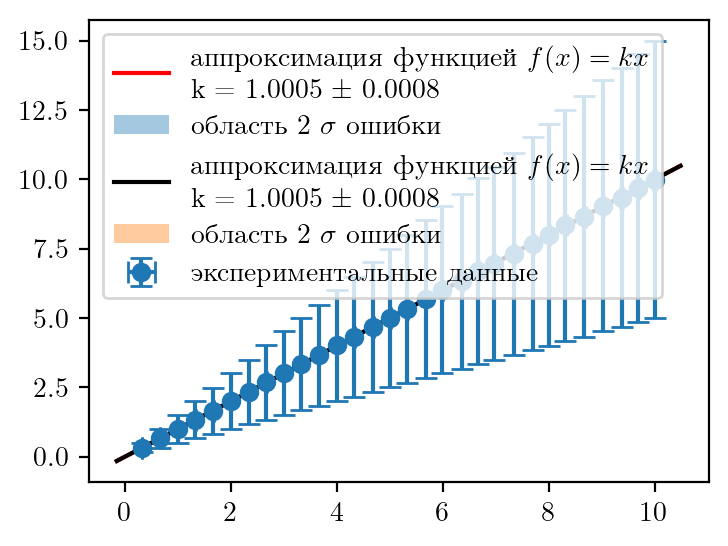

In [68]:
# Эксперимент с маленьким разбросом и большой погрешностью

x, y, xerr, yerr = gen_linear_data(10, 30, y_eps=0.003, x_eps=0.003)
yerr = 0.5*y
# function to approximate
fun_name = r"$f(x) = kx$"
def F(P, x):
    return P[0] * x
par_names_str = fr'''
k, 
'''
linear = Model(F)
mydata = RealData(x, y, sx=xerr, sy=yerr)
myodr = ODR(mydata, linear, beta0=[1.])
myoutput = myodr.run()
popt = myoutput.beta
pcov = myoutput.sd_beta.reshape(1, 1)**2


# экспериментальные точки
plt.errorbar(x, y, fmt="o", xerr=xerr, yerr=yerr, label="экспериментальные данные", capsize=4, ms=6)

## ODR approximation

err = np.sqrt(np.diag(pcov))
for v, er in zip(popt, err):
    print(v,'+-',er)
approx_label = f"аппроксимация функцией {fun_name}"

par_names = [x.split(',') for x in par_names_str.strip().split("\n") if (len(x) != 0)]
for i in range(len(par_names)):
    t = par_names[i]
    if len(t) == 2:
        name, units = t
    else:
        name, units = *t, ''
    approx_label += f"\n{name} = {err_pres_formatter(popt[i], err[i])}"
teorPoints = 50     
intent = 0.05   # отступ по бокам от обласи экспериментальных данных
a, b = x.min(), x.max()
X = np.linspace(a-(b-a)*intent, b+(b-a)*intent, num=teorPoints)
plt.plot(X, f(X, *popt), 'r', label=approx_label)
if (pcov != np.inf).all():
    nsigma = 2
    minA, maxA = lower_upper_limits(X, f, popt, pcov, nsigma=nsigma)  # pcov*10000000**2
    plt.fill_between(X, minA, maxA, alpha=0.4, label=f"область {nsigma} $\sigma$ ошибки")


## scipy approximation

# function to approximate
fun_name = r"$f(x) = kx$"
def f(x, k):
    return k * x
par_names_str = fr'''
k, 
'''
popt, pcov = curve_fit(f, x, y, sigma=yerr, absolute_sigma=False)

err = np.sqrt(np.diag(pcov))
for v, er in zip(popt, err):
    print(v,'+-',er)
approx_label = f"аппроксимация функцией {fun_name}"

par_names = [x.split(',') for x in par_names_str.strip().split("\n") if (len(x) != 0)]
for i in range(len(par_names)):
    t = par_names[i]
    if len(t) == 2:
        name, units = t
    else:
        name, units = *t, ''
    approx_label += f"\n{name} = {err_pres_formatter(popt[i], err[i])}"
teorPoints = 50     
intent = 0.05   # отступ по бокам от обласи экспериментальных данных
a, b = x.min(), x.max()
X = np.linspace(a-(b-a)*intent, b+(b-a)*intent, num=teorPoints)
plt.plot(X, f(X, *popt), 'black', label=approx_label)
if (pcov != np.inf).all():
    nsigma = 2
    minA, maxA = lower_upper_limits(X, f, popt, pcov, nsigma=nsigma)
    plt.fill_between(X, minA, maxA, alpha=0.4, label=f"область {nsigma} $\sigma$ ошибки")


plt.legend();

In [ ]:
chisq(popt)/(M-N)

Beta: [0.99818608]
Beta Std Error: [0.00082777]
Beta Covariance: [[0.00830359]]
Residual Variance: 8.251916110984012e-05
Inverse Condition #: 1.0
Reason(s) for Halting:
  Sum of squares convergence
0.998186076462941 +- 0.0008277714060069461
0.9981860748995788 +- 0.09112241361076977


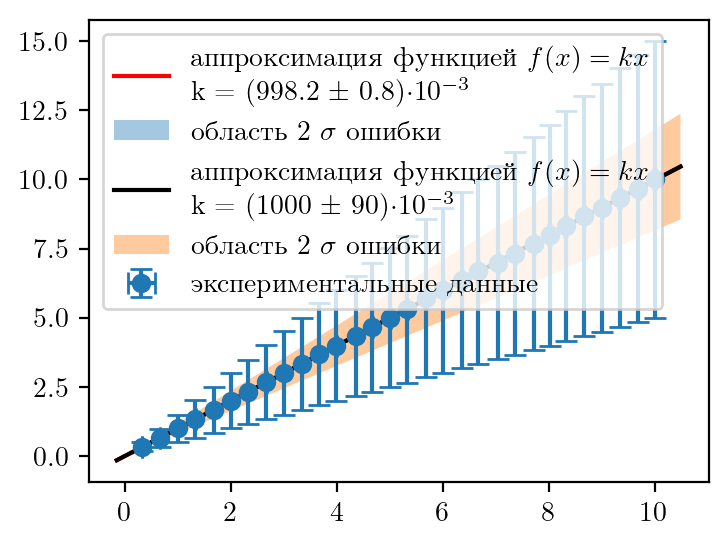

In [74]:
# Эксперимент с маленьким разбросом и большой погрешностью

x, y, xerr, yerr = gen_linear_data(10, 30, y_eps=0.003, x_eps=0.003)
yerr = 0.5*y
# function to approximate
fun_name = r"$f(x) = kx$"
def F(P, x):
    return P[0] * x
par_names_str = fr'''
k, 
'''
linear = Model(F)
mydata = RealData(x, y, sx=xerr, sy=yerr)

myodr = ODR(mydata, linear, beta0=[1.])

myoutput = myodr.run()

myoutput.pprint()

popt = myoutput.beta
pcov = myoutput.sd_beta.reshape(1, 1)**2


# экспериментальные точки
plt.errorbar(x, y, fmt="o", xerr=xerr, yerr=yerr, label="экспериментальные данные", capsize=4, ms=6)

## ODR approximation

err = np.sqrt(np.diag(pcov))
for v, er in zip(popt, err):
    print(v,'+-',er)
approx_label = f"аппроксимация функцией {fun_name}"

par_names = [x.split(',') for x in par_names_str.strip().split("\n") if (len(x) != 0)]
for i in range(len(par_names)):
    t = par_names[i]
    if len(t) == 2:
        name, units = t
    else:
        name, units = *t, ''
    approx_label += f"\n{name} = {err_pres_formatter(popt[i], err[i])}"
teorPoints = 50     
intent = 0.05   # отступ по бокам от обласи экспериментальных данных
a, b = x.min(), x.max()
X = np.linspace(a-(b-a)*intent, b+(b-a)*intent, num=teorPoints)
plt.plot(X, f(X, *popt), 'r', label=approx_label)
if (pcov != np.inf).all():
    nsigma = 2
    minA, maxA = lower_upper_limits(X, f, popt, pcov, nsigma=nsigma)  # pcov*10000000**2
    plt.fill_between(X, minA, maxA, alpha=0.4, label=f"область {nsigma} $\sigma$ ошибки")


## scipy approximation

# function to approximate
fun_name = r"$f(x) = kx$"
def f(x, k):
    return k * x
par_names_str = fr'''
k, 
'''
popt, pcov = curve_fit(f, x, y, sigma=yerr, absolute_sigma=True)

err = np.sqrt(np.diag(pcov))
for v, er in zip(popt, err):
    print(v,'+-',er)
approx_label = f"аппроксимация функцией {fun_name}"

par_names = [x.split(',') for x in par_names_str.strip().split("\n") if (len(x) != 0)]
for i in range(len(par_names)):
    t = par_names[i]
    if len(t) == 2:
        name, units = t
    else:
        name, units = *t, ''
    approx_label += f"\n{name} = {err_pres_formatter(popt[i], err[i])}"
teorPoints = 50     
intent = 0.05   # отступ по бокам от обласи экспериментальных данных
a, b = x.min(), x.max()
X = np.linspace(a-(b-a)*intent, b+(b-a)*intent, num=teorPoints)
plt.plot(X, f(X, *popt), 'black', label=approx_label)
if (pcov != np.inf).all():
    nsigma = 2
    minA, maxA = lower_upper_limits(X, f, popt, pcov, nsigma=nsigma)
    plt.fill_between(X, minA, maxA, alpha=0.4, label=f"область {nsigma} $\sigma$ ошибки")


plt.legend();

In [72]:
myoutput.sum_square, myoutput.sum_square_delta, myoutput.sum_square_eps

(0.002442252160588245, 8.824641946552607e-08, 0.0024421639141687795)

In [78]:
myoutput.sd_beta.reshape(1, 1)**2

array([[6.85205501e-07]])

In [81]:
((myoutput.sd_beta.reshape(1, 1)**2)[0, 0])/pcov[0, 0]

8.252212663565897e-05

In [82]:
myoutput.res_var

8.251916110984012e-05

In [83]:
myoutput.sd_beta**2/myoutput.cov_beta

array([[8.25191611e-05]])

In [84]:
pcov[0, 0], (myoutput.sd_beta**2)[0], myoutput.cov_beta

(0.008303294262252198, 6.852055006027164e-07, array([[0.00830359]]))

### Окончательный вариант

Beta: [1.00030549]
Beta Std Error: [0.00074505]
Beta Covariance: [[0.00833886]]
Residual Variance: 6.656718245036958e-05
Inverse Condition #: 1.0
Reason(s) for Halting:
  Sum of squares convergence
1.0003054943990837 +- 0.09131736010854956
1.0003054931253332 +- 0.09131571554600067


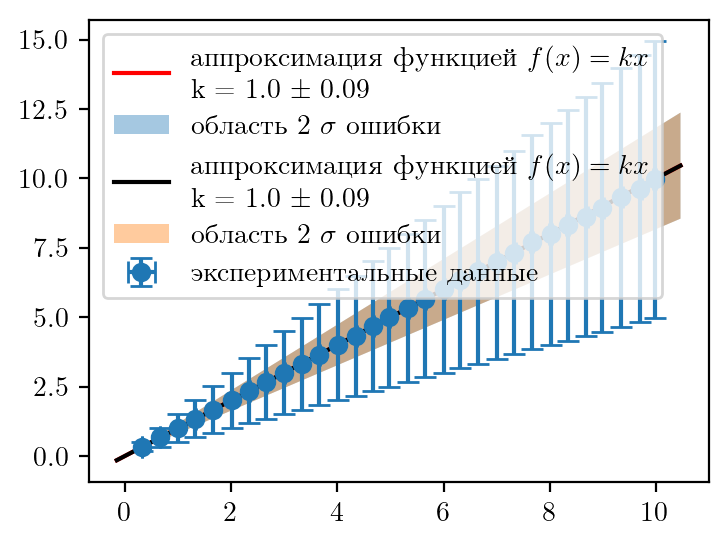

In [86]:
# Эксперимент с маленьким разбросом и большой погрешностью
absolute_sigma = True


x, y, xerr, yerr = gen_linear_data(10, 30, y_eps=0.003, x_eps=0.003)
yerr = 0.5*y
# function to approximate
fun_name = r"$f(x) = kx$"
def F(P, x):
    return P[0] * x
par_names_str = fr'''
k, 
'''
linear = Model(F)
mydata = RealData(x, y, sx=xerr, sy=yerr)

myodr = ODR(mydata, linear, beta0=[1.])

myoutput = myodr.run()

myoutput.pprint()

popt = myoutput.beta
if absolute_sigma:
    pcov = myoutput.cov_beta
else:
    pcov = myoutput.sd_beta.reshape(1, 1)**2

    

# экспериментальные точки
plt.errorbar(x, y, fmt="o", xerr=xerr, yerr=yerr, label="экспериментальные данные", capsize=4, ms=6)

## ODR approximation

err = np.sqrt(np.diag(pcov))
for v, er in zip(popt, err):
    print(v,'+-',er)
approx_label = f"аппроксимация функцией {fun_name}"

par_names = [x.split(',') for x in par_names_str.strip().split("\n") if (len(x) != 0)]
for i in range(len(par_names)):
    t = par_names[i]
    if len(t) == 2:
        name, units = t
    else:
        name, units = *t, ''
    approx_label += f"\n{name} = {err_pres_formatter(popt[i], err[i])}"
teorPoints = 50     
intent = 0.05   # отступ по бокам от обласи экспериментальных данных
a, b = x.min(), x.max()
X = np.linspace(a-(b-a)*intent, b+(b-a)*intent, num=teorPoints)
plt.plot(X, f(X, *popt), 'r', label=approx_label)
if (pcov != np.inf).all():
    nsigma = 2
    minA, maxA = lower_upper_limits(X, f, popt, pcov, nsigma=nsigma)  # pcov*10000000**2
    plt.fill_between(X, minA, maxA, alpha=0.4, label=f"область {nsigma} $\sigma$ ошибки")


## scipy approximation

# function to approximate
fun_name = r"$f(x) = kx$"
def f(x, k):
    return k * x
par_names_str = fr'''
k, 
'''
popt, pcov = curve_fit(f, x, y, sigma=yerr, absolute_sigma=absolute_sigma)

err = np.sqrt(np.diag(pcov))
for v, er in zip(popt, err):
    print(v,'+-',er)
approx_label = f"аппроксимация функцией {fun_name}"

par_names = [x.split(',') for x in par_names_str.strip().split("\n") if (len(x) != 0)]
for i in range(len(par_names)):
    t = par_names[i]
    if len(t) == 2:
        name, units = t
    else:
        name, units = *t, ''
    approx_label += f"\n{name} = {err_pres_formatter(popt[i], err[i])}"
teorPoints = 50     
intent = 0.05   # отступ по бокам от обласи экспериментальных данных
a, b = x.min(), x.max()
X = np.linspace(a-(b-a)*intent, b+(b-a)*intent, num=teorPoints)
plt.plot(X, f(X, *popt), 'black', label=approx_label)
if (pcov != np.inf).all():
    nsigma = 2
    minA, maxA = lower_upper_limits(X, f, popt, pcov, nsigma=nsigma)
    plt.fill_between(X, minA, maxA, alpha=0.4, label=f"область {nsigma} $\sigma$ ошибки")


plt.legend();